# Datasci207-Group-Project-Team-RIMS
## Hotel Cancellation - Random Forest Model

### Import libraries

In [2]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# !pip install gdown
import gdown
import os

sklearn.__version__

'1.2.2'

### Read in processed data from EDA

In [3]:
# Recall that EDA saved the split data for sharing (after necessary engineering such as regrouping, get_dummies, but before standarization or removing some categorical features)
file_path = '../data/data-processed/'

X_train = pd.read_csv(file_path+'X_train.csv', index_col=0)
X_val = pd.read_csv(file_path+'X_val.csv', index_col=0)
X_test= pd.read_csv(file_path+'X_test.csv', index_col=0)
Y_train = pd.read_csv(file_path+'Y_train.csv', index_col=0).squeeze()
Y_val = pd.read_csv(file_path+'Y_val.csv', index_col=0).squeeze()
Y_test = pd.read_csv(file_path+'Y_test.csv', index_col=0).squeeze()

numeric_features = ['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

excluded_features = ['Booking_ID', 'arrival_year'] 
cat_features = ['type_of_meal_plan', 
                'room_type_reserved',  
                'market_segment_type', 
                'repeated_guest', 
                'required_car_parking_space', 
                'arrival_month', 
                'arrival_date', 
                'arrival_week_of_day']

### Further feature engineering for modeling purpose

In [5]:
# Standardize data (only numerical features)
X_train_std = X_train.copy()
X_val_std = X_val.copy()
X_test_std = X_test.copy()

X_train_std[numeric_features] = (X_train[numeric_features] - X_train[numeric_features].mean())/X_train[numeric_features].std()
X_val_std[numeric_features] = (X_val[numeric_features] - X_train[numeric_features].mean())/X_train[numeric_features].std()
X_test_std[numeric_features] = (X_test[numeric_features] - X_train[numeric_features].mean())/X_train[numeric_features].std()

print ('Check the description of the post standarization of X_train_std')
display(X_train_std[numeric_features].describe())
display(X_val_std[numeric_features].describe())

print (f'\nThe shape of X_train_std after standarization is {X_train_std.shape}')
print (f'The shape of X_val_std after standarization is {X_val_std.shape}')
print (f'The shape of X_test_std after standarization is {X_test_std.shape}')


# Treat data imbalance
oversample_ob = RandomOverSampler(random_state=1234, sampling_strategy = 'minority')
X_train_std_os, Y_train_os = oversample_ob.fit_resample(X_train_std, Y_train)
# IN: if we do not want to do oversampling
# X_train_std_os, Y_train_os = X_train_std, Y_train

print (f'\nThe shape of X_train_std_os after sample imbalance treatment is {X_train_std_os.shape}')
print (f'The shape of Y_train_os after sample imbalance treatment is {Y_train_os.shape}')
display(Y_train_os.value_counts())

# Change all inputs as numerical for ML to work
X_train_std_os, Y_train_os, X_val_std, Y_val, X_test_std, Y_test = \
    X_train_std_os.astype(float), Y_train_os.astype(float), X_val_std.astype(float), Y_val.astype(float), X_test_std.astype(float), Y_test.astype(float)

# Comments on oversampling
print ('\nReasoning for using oversampling:')
print ('Note that we did seperate alternative experiment, where we do not conduct oversampling in train data.')
print ('As it turns out, although we see slightly higher overall accuracy results (~80.5% for train) but large by group accuracy where the minority group - cancellation group has accuracy of 65.5%,')
print ('While the majority group - non-cancellation group has accuracy of 88.1% in train. Therefore, we decided to use oversampling for most of our models from here on.')

Check the description of the post standarization of X_train_std


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04
mean,-1.111600e-16,1.501721e-17,3.101381e-17,-5.729394e-17,-9.238851e-17,-1.175260e-17,-4.570456e-18,-1.939179e-16,3.362550e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.562819e+00,-2.663556e-01,-9.345568e-01,-1.573812e+00,-9.962975e-01,-6.336118e-02,-8.602559e-02,-2.965883e+00,-7.871379e-01
25%,2.911025e-01,-2.663556e-01,-9.345568e-01,-8.579347e-01,-7.975669e-01,-6.336118e-02,-8.602559e-02,-6.627853e-01,-7.871379e-01
50%,2.911025e-01,-2.663556e-01,2.178868e-01,-1.420572e-01,-3.299656e-01,-6.336118e-02,-8.602559e-02,-1.126804e-01,-7.871379e-01
75%,2.911025e-01,-2.663556e-01,1.370330e+00,5.738203e-01,4.883367e-01,-6.336118e-02,-8.602559e-02,4.930660e-01,4.849185e-01
max,4.145024e+00,7.388437e+00,7.132548e+00,1.059611e+01,4.182387e+00,3.495173e+01,3.220542e+01,1.252195e+01,5.573144e+00


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000
mean,-0.031607,0.001993,-0.008790,0.025787,-0.000739,-0.002475,0.004221,-0.015698,-0.008825
std,0.999985,1.022447,1.004429,1.018810,1.008134,0.904644,0.974968,1.023698,0.992614
min,-3.562819,-0.266356,-0.934557,-1.573812,-0.996297,-0.063361,-0.086026,-2.965883,-0.787138
25%,0.291103,-0.266356,-0.934557,-0.857935,-0.797567,-0.063361,-0.086026,-0.671390,-0.787138
50%,0.291103,-0.266356,0.217887,-0.142057,-0.318276,-0.063361,-0.086026,-0.143369,-0.787138
75%,0.291103,-0.266356,1.370330,0.573820,0.464957,-0.063361,-0.086026,0.475857,0.484919
max,4.145024,7.388437,5.980105,10.596106,4.182387,34.951732,27.194676,7.502745,5.573144



The shape of X_train_std after standarization is (21765, 79)
The shape of X_val_std after standarization is (7255, 79)
The shape of X_test_std after standarization is (7255, 79)

The shape of X_train_std_os after sample imbalance treatment is (29216, 79)
The shape of Y_train_os after sample imbalance treatment is (29216,)


booking_status
0.0    14608
1.0    14608
Name: count, dtype: int64


Reasoning for using oversampling:
Note that we did seperate alternative experiment, where we do not conduct oversampling in train data.
As it turns out, although we see slightly higher overall accuracy results (~80.5% for train) but large by group accuracy where the minority group - cancellation group has accuracy of 65.5%,
While the majority group - non-cancellation group has accuracy of 88.1% in train. Therefore, we decided to use oversampling for most of our models from here on.


In [7]:
# Util functions for later evaluation:

def confusion_matrix_plot(conf_matrix, plot_name):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.7)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title (plot_name)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

def model_performance_metrics_comp (model, X, Y, class_names, binary_flag=False):
    Y_pred = model.predict(X)

    # to handle the situation where model predict are just probabilities and only two classes (such as softmax dense output neural network)
    if binary_flag:
        Y_pred = np.where(Y_pred>0.5, 1, 0)
    if binary_flag:
        average = None
    else:
        average = None
    
    cm = tf.math.confusion_matrix(
    Y,
    Y_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
    ).numpy()
    acc_by_class = np.array([cm[i,i]/cm[i].sum() for i in range(len(cm[0]))]) 

    acc = metrics.accuracy_score(Y, Y_pred)
    precision = metrics.precision_score(Y, Y_pred, average=average)
    recall = metrics.recall_score(Y, Y_pred, average=average)
    f1 = metrics.f1_score(Y, Y_pred, average=average)

    res_df = pd.DataFrame(np.concatenate([[acc_by_class, precision, recall, f1]], axis=0), \
                          index = ['Accuracy by class','Precision', 'Recall', 'F1'], \
                            columns=class_names)

    return (acc, res_df)

### Improvement over baseline with Random Forest

In [8]:
# Initial random forest model
rf_clf_0  = sklearn.ensemble.RandomForestClassifier(n_estimators=2,
                                            n_jobs=3,
                                            random_state=1234,
                                            max_depth=5)

rf_clf_0.fit(X_train_std_os, Y_train_os)

RandomForestClassifier(max_depth=5, n_estimators=2, n_jobs=3, random_state=1234)

In [9]:
# Evaluate the train data performance
acc_train_rf_0, res_df_train_rf_0 = model_performance_metrics_comp (rf_clf_0, X_train_std_os, Y_train_os,\
                                                                         ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('Train data accuracy of initial random forest model is:')
print(f'{acc_train_rf_0:.1%}')
print ('The by class metrics are: ')
display(res_df_train_rf_0.apply(lambda x: x.map('{:.1%}'.format)))

Train data accuracy of initial random forest model is:
78.0%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,84.4%,71.7%
Precision,74.9%,82.1%
Recall,84.4%,71.7%
F1,79.4%,76.6%


In [10]:
# Tune random forest model
rf_clf2_0  = sklearn.ensemble.RandomForestClassifier(n_estimators=2,
                                            n_jobs=3,
                                            random_state=1234,
                                            max_depth=5)

# Grid of parameters to choose from
parameters = {
    "n_estimators": np.arange(30, 60, 10),
    "max_depth": list(np.arange(2, 20, 5)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5, 10],

}

# Set the metrics used to compare models
# metrics_score = metrics.make_scorer(metrics.accuracy_score)
metrics_score = metrics.make_scorer(metrics.f1_score)

# Grid search and choose the best model
grids_obj_rf = GridSearchCV(rf_clf2_0, parameters, scoring=metrics_score, cv=8, n_jobs=3)
grids_obj_rf.fit(X_train_std_os, Y_train_os)

# Find the best estimator
rf_clf_tuned = grids_obj_rf.best_estimator_

# Fit the best model to the data
rf_clf_tuned.fit(X_train_std_os, Y_train_os)

RandomForestClassifier(max_depth=17, n_estimators=30, n_jobs=3,
                       random_state=1234)

In [12]:
# Evaluate the train data performance
acc_train_rf_tuned, res_df_train_rf_tuned = model_performance_metrics_comp (rf_clf_tuned, X_train_std_os, Y_train_os,\
                                                                         ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('Train data accuracy of tuned random forest model is:')
print(f'{acc_train_rf_tuned:.1%}')
print ('The by class metrics are: ')
display(res_df_train_rf_tuned.apply(lambda x: x.map('{:.1%}'.format)))

acc_val_rf_tuned, res_df_val_rf_tuned = model_performance_metrics_comp (rf_clf_tuned, X_val_std, Y_val,\
                                                                         ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('Validation data accuracy of tuned random forest model is:')
print(f'{acc_val_rf_tuned:.1%}')
print ('The by class metrics are: ')
display(res_df_val_rf_tuned.apply(lambda x: x.map('{:.1%}'.format)))

Train data accuracy of tuned random forest model is:
92.3%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,94.0%,90.6%
Precision,90.9%,93.8%
Recall,94.0%,90.6%
F1,92.4%,92.1%


Validation data accuracy of tuned random forest model is:
87.8%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,90.6%,82.0%
Precision,91.3%,80.7%
Recall,90.6%,82.0%
F1,91.0%,81.4%


Prepare model results on test data for tuned random forest model:

Test data accuracy of tuned random forest model is:
The overall accuracy is: 88.6%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,91.6%,82.4%
Precision,91.4%,82.7%
Recall,91.6%,82.4%
F1,91.5%,82.6%


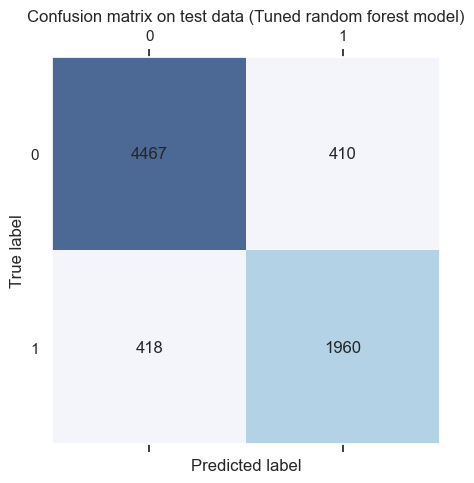

The overall accuracy on train data is 92.3%
The overall accuracy on validation data is 87.8%
The overall accuracy on test data is 88.6%

1.The TP is 4467, TN is 1960, FP is 410, FN is 418.

2.The accuracy for cancellation group is 82.4%, and the accuracy for non-cancellation group is 91.6%.
3.The precision for cancellation group is 82.7%, the recall for cancellation group is 82.4%, and f1 for cancellation group is 82.6%.


In [13]:
'''Look at the results on test data (tuned random forest)'''
print ('Prepare model results on test data for tuned random forest model:')

(acc_test_rf_tuned, res_df_test_rf_tuned) = model_performance_metrics_comp (rf_clf_tuned, X_test_std, Y_test, \
                                                             ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('\nTest data accuracy of tuned random forest model is:')
print (f'The overall accuracy is: {acc_test_rf_tuned:.1%}')
print ('The by class metrics are: ')
display(res_df_test_rf_tuned.apply(lambda x: x.map('{:.1%}'.format)))

'''Comments and confusion matrix'''
'''confusion matrix plot on test data'''
Y_test_pred_rf_tuned = np.where(rf_clf_tuned.predict(X_test_std).flatten()>0.5,1,0) # do not really need the external np.where() here

conf_matrix_test_rf_tuned = tf.math.confusion_matrix(
    Y_test,
    Y_test_pred_rf_tuned,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix_test_rf_tuned

confusion_matrix_plot(conf_matrix_test_rf_tuned.numpy(), 'Confusion matrix on test data (Tuned random forest model)')
print (f'The overall accuracy on train data is {acc_train_rf_tuned:.1%}')
print (f'The overall accuracy on validation data is {acc_val_rf_tuned:.1%}')
print (f'The overall accuracy on test data is {acc_test_rf_tuned:.1%}')

cancel_accuracy_rf_tuned = res_df_test_rf_tuned.loc['Accuracy by class','Cancellation']
non_cancel_accuracy_rf_tuned = res_df_test_rf_tuned.loc['Accuracy by class','Non_cancellation']
precision_rf_tuned = res_df_test_rf_tuned.loc['Precision','Cancellation']
recall_rf_tuned = res_df_test_rf_tuned.loc['Recall','Cancellation']
f1_rf_tuned = res_df_test_rf_tuned.loc['F1','Cancellation']

print (f'\n1.The TP is {conf_matrix_test_rf_tuned.numpy()[0,0]}, TN is {conf_matrix_test_rf_tuned.numpy()[1,1]}, FP is {conf_matrix_test_rf_tuned.numpy()[0,1]}, FN is {conf_matrix_test_rf_tuned.numpy()[1,0]}.')
print (f'\n2.The accuracy for cancellation group is {cancel_accuracy_rf_tuned:.1%}, and the accuracy for non-cancellation group is {non_cancel_accuracy_rf_tuned:.1%}.')
print (f'3.The precision for cancellation group is {precision_rf_tuned:.1%}, the recall for cancellation group is {recall_rf_tuned:.1%}, and f1 for cancellation group is {f1_rf_tuned:.1%}.')

### Important features for tuned random forest model

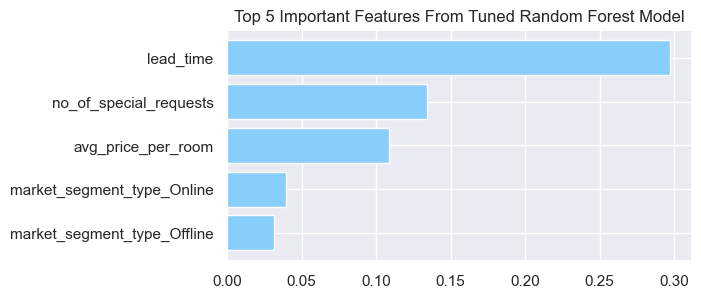

In [14]:
feature_names_rf_tuned = X_train_std_os.columns
importances_rf_tuned = rf_clf_tuned.feature_importances_
top_5_idx_rf_tuned = np.argsort(importances_rf_tuned)[::-1][:5]
if len(importances_rf_tuned) != len(feature_names_rf_tuned):
    raise ValueError ('Weights len does not equal to feature names len in tuned random forest model')

plt.figure(figsize = (6,3))
plt.barh(feature_names_rf_tuned[top_5_idx_rf_tuned].tolist()[::-1], importances_rf_tuned[top_5_idx_rf_tuned][::-1], align='center', color='lightskyblue')
plt.title('Top 5 Important Features From Tuned Random Forest Model')
plt.show()

### Optional model (not presented in slides) - Improvement over baseline with Gradient boost tree
#### Reason: no better than tuned random forest in train data

In [15]:
# Initial gradient boost
gb_clf_0 = sklearn.ensemble.GradientBoostingClassifier(random_state=1234)
gb_clf_0.fit(X_train_std_os, Y_train_os)

GradientBoostingClassifier(random_state=1234)

In [16]:
# Evaluate the train data performance
acc_train_gbc_0, res_df_train_gbc_0 = model_performance_metrics_comp (gb_clf_0, X_train_std_os, Y_train_os,\
                                                                         ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('Train data accuracy of initial gradient boosting model is:')
print(f'{acc_train_gbc_0:.1%}')
print ('The by class metrics are: ')
display(res_df_train_gbc_0.apply(lambda x: x.map('{:.1%}'.format)))

Train data accuracy of initial gradient boosting model is:
82.9%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,85.1%,80.8%
Precision,81.6%,84.4%
Recall,85.1%,80.8%
F1,83.3%,82.6%


In [17]:
# Tune gradient boost model
gbc_tuned = sklearn.ensemble.GradientBoostingClassifier(
    init=sklearn.ensemble.AdaBoostClassifier(random_state=1234), random_state=1234
)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [200, 300],
    "subsample": [0.8, 1],
    "max_features": [0.8, 1],
    "learning_rate": np.arange(0.1, 0.3, 0.1),
}

# Type of scoring used to compare parameter combinations
metrics_score = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=metrics_score, cv=5, n_jobs = 3)
grid_obj = grid_obj.fit(X_train_std_os, Y_train_os)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train_std_os, Y_train_os)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1234),
                           learning_rate=0.2, max_features=0.8,
                           n_estimators=300, random_state=1234, subsample=0.8)

In [18]:
# Evaluate the train data performance
acc_train_gbc_tuned, res_df_train_gbc_tuned = model_performance_metrics_comp (gbc_tuned, X_train_std_os, Y_train_os,\
                                                                         ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('Train data accuracy of tuned random forest model is:')
print(f'{acc_train_gbc_tuned:.1%}')
print ('The by class metrics are: ')
display(res_df_train_gbc_tuned.apply(lambda x: x.map('{:.1%}'.format)))

acc_val_gbc_tuned, res_df_val_gbc_tuned = model_performance_metrics_comp (gbc_tuned, X_val_std, Y_val,\
                                                                         ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('Validation data accuracy of tuned random forest model is:')
print(f'{acc_val_gbc_tuned:.1%}')
print ('The by class metrics are: ')
display(res_df_val_gbc_tuned.apply(lambda x: x.map('{:.1%}'.format)))

Train data accuracy of tuned random forest model is:
88.4%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,89.2%,87.6%
Precision,87.8%,89.0%
Recall,89.2%,87.6%
F1,88.5%,88.3%


Validation data accuracy of tuned random forest model is:
86.7%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,87.7%,84.6%
Precision,92.2%,76.7%
Recall,87.7%,84.6%
F1,89.9%,80.5%


Prepare model results on test data for tuned gradient boost model:

Test data accuracy of tuned gradient boost model is:
The overall accuracy is: 86.3%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,87.6%,83.6%
Precision,91.7%,76.6%
Recall,87.6%,83.6%
F1,89.6%,80.0%


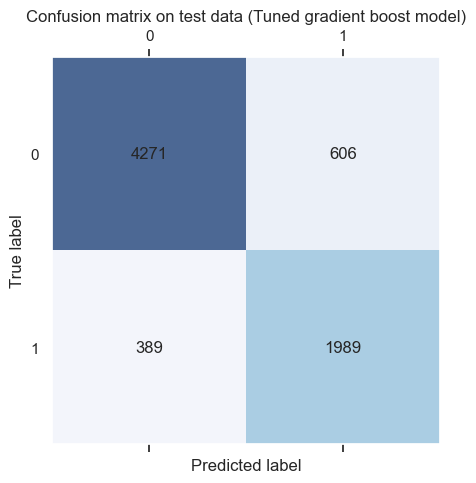

The overall accuracy on train data is 86.7%
The overall accuracy on validation data is 86.7%
The overall accuracy on test data is 86.3%

1.The TP is 4271, TN is 1989, FP is 606, FN is 389.

2.The accuracy for cancellation group is 83.6%, and the accuracy for non-cancellation group is 87.6%.
3.The precision for cancellation group is 76.6%, the recall for cancellation group is 83.6%, and f1 for cancellation group is 80.0%.


In [19]:
'''Look at the results on test data (tuned gradient boost)'''
print ('Prepare model results on test data for tuned gradient boost model:')
(acc_test_gbc_tuned, res_df_test_gbc_tuned) = model_performance_metrics_comp (gbc_tuned, X_test_std, Y_test, \
                                                             ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('\nTest data accuracy of tuned gradient boost model is:')
print (f'The overall accuracy is: {acc_test_gbc_tuned:.1%}')
print ('The by class metrics are: ')
display(res_df_test_gbc_tuned.apply(lambda x: x.map('{:.1%}'.format)))

'''Comments and confusion matrix'''
'''confusion matrix plot on test data'''
Y_test_pred_gbc_tuned = np.where(gbc_tuned.predict(X_test_std).flatten()>0.5,1,0) # do not really need the external np.where() here

conf_matrix_test_gbc_tuned = tf.math.confusion_matrix(
    Y_test,
    Y_test_pred_gbc_tuned,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix_test_gbc_tuned

confusion_matrix_plot(conf_matrix_test_gbc_tuned.numpy(), 'Confusion matrix on test data (Tuned gradient boost model)')
print (f'The overall accuracy on train data is {acc_val_gbc_tuned:.1%}')
print (f'The overall accuracy on validation data is {acc_val_gbc_tuned:.1%}')
print (f'The overall accuracy on test data is {acc_test_gbc_tuned:.1%}')

cancel_accuracy_gbc_tuned = res_df_test_gbc_tuned.loc['Accuracy by class','Cancellation']
non_cancel_accuracy_gbc_tuned = res_df_test_gbc_tuned.loc['Accuracy by class','Non_cancellation']
precision_gbc_tuned = res_df_test_gbc_tuned.loc['Precision','Cancellation']
recall_gbc_tuned = res_df_test_gbc_tuned.loc['Recall','Cancellation']
f1_gbc_tuned = res_df_test_gbc_tuned.loc['F1','Cancellation']

print (f'\n1.The TP is {conf_matrix_test_gbc_tuned.numpy()[0,0]}, TN is {conf_matrix_test_gbc_tuned.numpy()[1,1]}, FP is {conf_matrix_test_gbc_tuned.numpy()[0,1]}, FN is {conf_matrix_test_gbc_tuned.numpy()[1,0]}.')
print (f'\n2.The accuracy for cancellation group is {cancel_accuracy_gbc_tuned:.1%}, and the accuracy for non-cancellation group is {non_cancel_accuracy_gbc_tuned:.1%}.')
print (f'3.The precision for cancellation group is {precision_gbc_tuned:.1%}, the recall for cancellation group is {recall_gbc_tuned:.1%}, and f1 for cancellation group is {f1_gbc_tuned:.1%}.')

##### Comment on Gradient Boost: we decided not to proceed with gradient boost because the tuned model does not do better than the tuned random forest in terms of F1 or accruacy in train. 